## Introducción a Keras para Deep Learning

<div class="alert alert-block alert-info" style="font-size:16px;">
    <b>Keras</b> es una librería de redes neuronales en Python que puede correr sobre varios backends (e.g. Tensorflow). Con ella es posible armar modelos de Deep Learning muy fácilmente. Utilizar directamente Tensorflow tiene un montón de facilidades, pero el proceso puede ser difícil, especialmente para quienes son nuevos en Deep Learning. Keras está ganando popularidad. Esta es una mini intro. <br>
    <br>
Podemos decir que los pasos básicos para la construcción de un modelo son:
    <br>

<b>1.</b> Armar el modelo. <br>
<b>2.</b> Elegir la loss function y el optimizador y compilar el modelo. <br>
<b>3.</b> Entrenar el modelo. <br>
<b>4.</b> Evaluar el modelo/hacer predicciones. <br>
<br> 

Vamos a realizar estos pasos más abajo. </div>





<div class="alert alert-block alert-info" style="font-size:16px;">
<b> Paso 0. Importar datos de MNIST.</b>
</div>

/home/javkrei/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/javkrei/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/javkrei/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/javkrei/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

11493376/11490434 [==============================] - 8s 1us/step


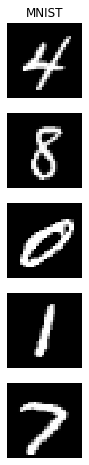

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
# para rotar las imágenes:
from scipy import ndimage

# usar las facilidades de keras para importar MNIST
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

enc = OneHotEncoder(handle_unknown='ignore')
# onehot-encodear el train y el test set
enc.fit(y_train.reshape(-1,1))
y_train_onehot = enc.transform(y_train.reshape(-1,1)).toarray()
y_test_onehot = enc.transform(y_test.reshape(-1,1)).toarray()

# elegimos 2200 ejemplos de MNIST aleatoriamente

# 2000 para entrenar
idx = np.random.randint(x_train.shape[0], size=2200)
x_train_sample = x_train[idx[0:2000],:,:]
y_train_sample_onehot = y_train_onehot[idx[0:2000],:]

# 200 ejemplos para el conjunto de validación (early stopping)
x_val_1 = x_train[idx[2000:2200],:,:]
y_val_1 = y_train[idx[2000:2200]]
y_val_1_onehot = enc.transform(y_val_1.reshape(-1,1)).toarray()

# mostrar algunas imágenes para saber de qué se trata
fig, axes = plt.subplots(5,1,figsize=(16,8))
axes[0].set_title("MNIST")
for i in range(5):
    axes[i].set_axis_off()
    axes[i].imshow(x_train_sample[i,:,:], interpolation='nearest', cmap='gray')

<div class="alert alert-block alert-info" style="font-size:16px;">
<b> 1. Armar el modelo.</b>
</div>

In [2]:
# se construye un modelo secuencial en keras, se inicializan los pesos aleatoriamnete con una distribución normal
# centrada en 0 y con desviación estándar 1/sqrt(n_in), donde n_in es el tamaño del input del layer

# así definimos un modelo secuencial en el cual los inputs fluyen de una capa a otra en la secuencia
model = tf.keras.models.Sequential()

# model.add(...) permite adicionar capas al modelo
# construimos un modelo con dos capas ocultas, una de 512 unidades y otra de 256
# el output son diez unidades, una por cada posible dígito (0,1,2,...,9)

model.add(tf.keras.layers.Flatten()) # Flatten() es una capa para "aplastar las imágenes"
        
model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu, # Dense(...) es una capa totalmente conectada 
                                                            # (hay un peso por cada par de unidades de la capa C a la capa C+1)
                                                            # activation permite definir la función de activación, por ejemplo,
                                                            # relu (rectified linear unit), o linear (sin función de activación)
                              kernel_initializer=tf.keras.initializers.random_normal(mean=0, stddev=np.sqrt(1/784))))
                                                            # kernel_initializer permite inicializar los valores de los pesos
model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu,
                              kernel_initializer=tf.keras.initializers.random_normal(mean=0, stddev=np.sqrt(1/512))))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax,
                              kernel_initializer=tf.keras.initializers.random_normal(mean=0, stddev=np.sqrt(1/256))))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


<div class="alert alert-block alert-info" style="font-size:16px;">
<b> 2. Elegir la loss function y el optimizador y compilar el modelo. </b>
</div>

In [3]:
# en este caso utilizamos Adam como optim izador con learning rate 10e-3
optimizer = tf.keras.optimizers.Adam(lr=0.001)


# la loss es la crossentropy
loss = tf.keras.losses.categorical_crossentropy

# se compila el modelo
# las métricas con el parámetro metrics permite monitorear la evolución del modelo
# en este caso elegimos la categorical accuracy y la categorical crossentropy
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['categorical_accuracy', 'categorical_crossentropy'])


<div class="alert alert-block alert-info" style="font-size:16px;">
<b> 3. Entrenar el modelo.</b>
</div>

In [4]:
# se entrena el modelo con tamaño del batch 100, usando el primer conjunto de validación para early stopping
# para ello se utiliza la función model.fit(...)
# NOTA: utilizar fit múltiples veces con diferentes datos continúa entrenando el modelo
out = model.fit(x_train_sample, 
          y_train_sample_onehot, 
          batch_size=100,
          epochs=100,
          validation_data=(x_val_1, y_val_1_onehot))

Train on 2000 samples, validate on 200 samples
Epoch 1/100
2000/2000 [==============================] - 0s 145us/sample - loss: 1.2219 - categorical_accuracy: 0.6735 - categorical_crossentropy: 1.2219 - val_loss: 0.5772 - val_categorical_accuracy: 0.8200 - val_categorical_crossentropy: 0.5772
Epoch 2/100
2000/2000 [==============================] - 0s 56us/sample - loss: 0.3952 - categorical_accuracy: 0.8845 - categorical_crossentropy: 0.3952 - val_loss: 0.5049 - val_categorical_accuracy: 0.8550 - val_categorical_crossentropy: 0.5049
Epoch 3/100
2000/2000 [==============================] - 0s 58us/sample - loss: 0.2531 - categorical_accuracy: 0.9200 - categorical_crossentropy: 0.2531 - val_loss: 0.4245 - val_categorical_accuracy: 0.8900 - val_categorical_crossentropy: 0.4245
Epoch 4/100
2000/2000 [==============================] - 0s 59us/sample - loss: 0.1603 - categorical_accuracy: 0.9550 - categorical_crossentropy: 0.1603 - val_loss: 0.3444 - val_categorical_accuracy: 0.9000 - val_c

Epoch 34/100
2000/2000 [==============================] - 0s 51us/sample - loss: 5.9145e-04 - categorical_accuracy: 1.0000 - categorical_crossentropy: 5.9145e-04 - val_loss: 0.4032 - val_categorical_accuracy: 0.9400 - val_categorical_crossentropy: 0.4032
Epoch 35/100
2000/2000 [==============================] - 0s 51us/sample - loss: 5.4727e-04 - categorical_accuracy: 1.0000 - categorical_crossentropy: 5.4727e-04 - val_loss: 0.4093 - val_categorical_accuracy: 0.9400 - val_categorical_crossentropy: 0.4093
Epoch 36/100
2000/2000 [==============================] - 0s 59us/sample - loss: 5.1292e-04 - categorical_accuracy: 1.0000 - categorical_crossentropy: 5.1292e-04 - val_loss: 0.4076 - val_categorical_accuracy: 0.9400 - val_categorical_crossentropy: 0.4076
Epoch 37/100
2000/2000 [==============================] - 0s 57us/sample - loss: 4.8433e-04 - categorical_accuracy: 1.0000 - categorical_crossentropy: 4.8433e-04 - val_loss: 0.4104 - val_categorical_accuracy: 0.9400 - val_categorical_c

2000/2000 [==============================] - 0s 47us/sample - loss: 1.2184e-04 - categorical_accuracy: 1.0000 - categorical_crossentropy: 1.2184e-04 - val_loss: 0.4628 - val_categorical_accuracy: 0.9350 - val_categorical_crossentropy: 0.4628
Epoch 67/100
2000/2000 [==============================] - 0s 48us/sample - loss: 1.1773e-04 - categorical_accuracy: 1.0000 - categorical_crossentropy: 1.1773e-04 - val_loss: 0.4675 - val_categorical_accuracy: 0.9350 - val_categorical_crossentropy: 0.4675
Epoch 68/100
2000/2000 [==============================] - 0s 47us/sample - loss: 1.1369e-04 - categorical_accuracy: 1.0000 - categorical_crossentropy: 1.1369e-04 - val_loss: 0.4661 - val_categorical_accuracy: 0.9350 - val_categorical_crossentropy: 0.4661
Epoch 69/100
2000/2000 [==============================] - 0s 49us/sample - loss: 1.1008e-04 - categorical_accuracy: 1.0000 - categorical_crossentropy: 1.1008e-04 - val_loss: 0.4699 - val_categorical_accuracy: 0.9350 - val_categorical_crossentropy: 

2000/2000 [==============================] - 0s 49us/sample - loss: 4.7742e-05 - categorical_accuracy: 1.0000 - categorical_crossentropy: 4.7742e-05 - val_loss: 0.5002 - val_categorical_accuracy: 0.9350 - val_categorical_crossentropy: 0.5002
Epoch 99/100
2000/2000 [==============================] - 0s 47us/sample - loss: 4.6512e-05 - categorical_accuracy: 1.0000 - categorical_crossentropy: 4.6512e-05 - val_loss: 0.5005 - val_categorical_accuracy: 0.9350 - val_categorical_crossentropy: 0.5005
Epoch 100/100
2000/2000 [==============================] - 0s 47us/sample - loss: 4.5541e-05 - categorical_accuracy: 1.0000 - categorical_crossentropy: 4.5541e-05 - val_loss: 0.5021 - val_categorical_accuracy: 0.9350 - val_categorical_crossentropy: 0.5021


<div class="alert alert-block alert-info" style="font-size:16px;">
<b> 4. Evaluar el modelo/hacer predicciones. </b>
</div>

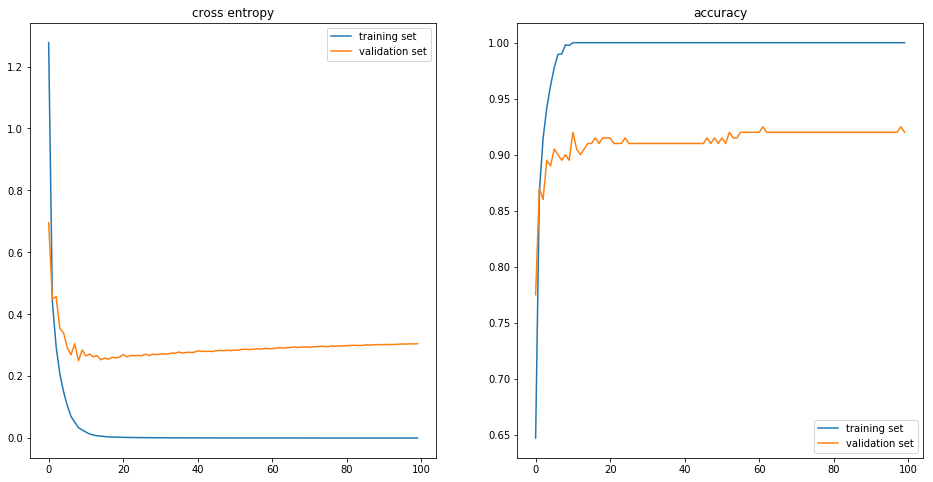

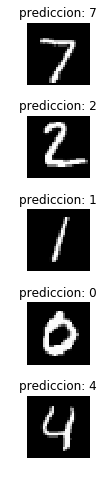

In [8]:
# mostrar la evaluación del modelo:
# Graficar accuracy para training, test y validation sets
fig, axes = plt.subplots(1,2,figsize=(16,8))
axes[0].set_title("cross entropy")
axes[1].set_title("accuracy")
axes[0].plot(out.history['categorical_crossentropy'], label='training set')
axes[0].plot(out.history['val_categorical_crossentropy'], label='validation set')
axes[0].legend()
axes[1].plot(out.history['categorical_accuracy'], label='training set')
axes[1].plot(out.history['val_categorical_accuracy'], label='validation set')
axes[1].legend()

# podemos hacer predicciones en el test set:
# para eso utilizamos la función model.predict(...)

predicted = np.argmax(model.predict(x_test[0:5]), axis=1)

# mostrar algunas imágenes para saber de qué se trata
fig, axes = plt.subplots(5,1,figsize=(16,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
axes[0].set_title("MNIST")
for i in range(5):
    axes[i].set_title("prediccion: " + str(predicted[i]))
    axes[i].set_axis_off()
    axes[i].imshow(x_test[i,:,:], interpolation='nearest', cmap='gray')
